In [1]:
# coding=utf-8
# Copyright 2022 The Ravens Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Ravens main training script."""

import os
import pickle

import numpy as np
import tensorflow as tf
from absl import app, flags

from ravens import agents, dataset, tasks
from ravens.environments.environment import Environment

import matplotlib.pyplot as plt

import os
import pickle
import shutil
import warnings
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import mmcv
import numpy as np
import tensorflow as tf
import torch
from depth.apis import multi_gpu_test, single_gpu_test
from depth.datasets import build_dataloader, build_dataset
from depth.datasets.pipelines import Compose
from depth.models import build_depther
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint, wrap_fp16_model
from mmcv.utils import DictAction
from torchvision import transforms
from ravens.utils import utils
from ravens import tasks
from ravens.tasks import cameras

2022-12-29 00:00:49.462989: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
pybullet build time: May 20 2022 19:43:01


In [2]:
train_dir="../"
assets_root="./ravens/environments/assets/"
disp=False
task_name="block-insertion"
agent="transporter"
n_demos=10
n_steps=400
data_dir="../dataset/"
root_dir="../"
# depth_checkpoint_file="../checkpoints/binsformer_swint_nyu_converted.pth"
# depth_config_file="../Monocular-Depth-Estimation-Toolbox/configs/binsformer/binsformer_swint_w7_nyu.py"
depth_checkpoint_file="../checkpoints/adabins_efnetb5_kitti.pth" 
depth_config_file="../Monocular-Depth-Estimation-Toolbox/configs/adabins/adabins_efnetb5ap_kitti_24e.py"
gpu=0
gpu_limit=9
shared_memory=False
n_runs=1
train_run=0

In [3]:
# Configure which GPU to use.
cfg = tf.config.experimental
gpus = cfg.list_physical_devices("GPU")
if not gpus:
    print("No GPUs detected. Running with CPU.")
else:
    cfg.set_visible_devices(gpus[gpu], "GPU")

# Configure how much GPU to use (in Gigabytes).
if gpu_limit is not None:
    mem_limit = 1024 * gpu_limit
    dev_cfg = [cfg.VirtualDeviceConfiguration(memory_limit=mem_limit)]
    cfg.set_virtual_device_configuration(gpus[0], dev_cfg)

# Load train and test datasets.
train_dataset = dataset.Dataset(
    os.path.join(data_dir, f"{task_name}-train"),
    depth_config_file,
    depth_checkpoint_file,
)
test_dataset = dataset.Dataset(
    os.path.join(data_dir, f"{task_name}-test"),
    depth_config_file,
    depth_checkpoint_file,
)
name = f"{task_name}-{agent}-{n_demos}-{train_run}"
agent = agents.names[agent](name, task_name, train_dir)

2022-12-29 00:01:11.751294: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-29 00:01:11.751597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 00:01:11.754742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.61GiB deviceMemoryBandwidth: 298.08GiB/s
2022-12-29 00:01:11.754798: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-29 00:01:11.757911: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-29 00:01:11.760564: I tensorflow/stream_executor/platform/default/d

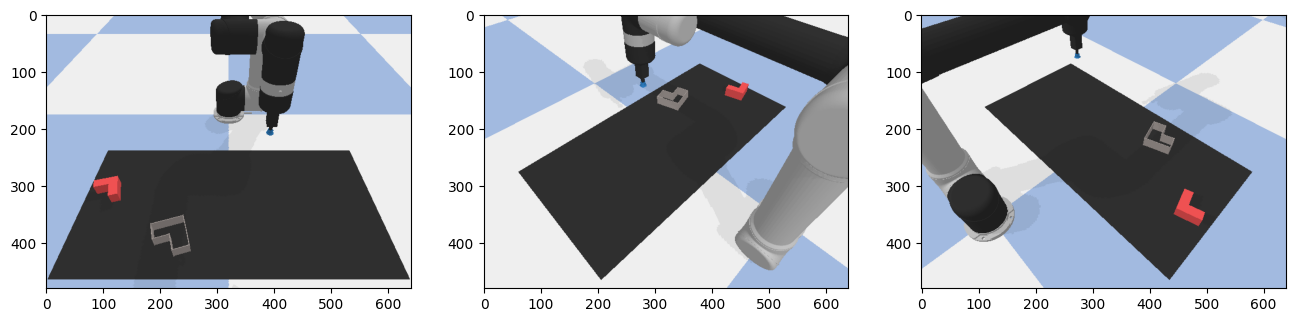

: 

In [14]:
(obs, act, _, _), _ = train_dataset.sample()
img = agent.get_image(obs)

fig, axs = plt.subplots(1, 3, figsize=(16, 16))
for i in range(3):
    axs[i].imshow(obs["color"][i])
    # axs[i].imshow(obs["depth"][i])
    # axs[i].imshow(img[:, :, 3:]/255)
    # axs[i].imshow(colormaps[i]/255)
    # axs[i].imshow(heightmaps[i]/255)

In [19]:
colormaps.shape, heightmaps.shape

((3, 320, 160, 3), (3, 320, 160))

In [7]:
heightmaps, colormaps = utils.reconstruct_heightmaps(
      obs['color'], obs['depth'], agent.cam_config, agent.bounds, agent.pix_size)
colormaps = np.float32(colormaps)
heightmaps = np.float32(heightmaps)
np.unique(colormaps), np.unique(heightmaps)

(array([  0.,  44.,  47.,  52.,  62.,  63.,  64.,  81.,  82., 103., 105.,
        109., 111., 112., 118., 132., 135., 143., 150., 153., 161., 162.,
        165., 173., 174., 183., 185., 186., 208., 222., 224., 239.],
       dtype=float32),
 array([0.        , 0.00023642, 0.00023953, ..., 0.04175526, 0.04175908,
        0.04176306], dtype=float32))

In [35]:
colormaps.shape

(3, 320, 160, 3)

In [30]:
# Configure which GPU to use.
cfg = tf.config.experimental
gpus = cfg.list_physical_devices("GPU")
if not gpus:
    print("No GPUs detected. Running with CPU.")
else:
    cfg.set_visible_devices(gpus[gpu], "GPU")

# Configure how much GPU to use (in Gigabytes).
if gpu_limit is not None:
    mem_limit = 1024 * gpu_limit
    dev_cfg = [cfg.VirtualDeviceConfiguration(memory_limit=mem_limit)]
    cfg.set_virtual_device_configuration(gpus[0], dev_cfg)

# Initialize environment and task.
env = Environment(assets_root, disp=disp, shared_memory=shared_memory, hz=480)
task = tasks.names[task_name]()
task.mode = "test"

# Load test dataset.
ds = dataset.Dataset(
    os.path.join(data_dir, f"{task_name}-test"),
    depth_config_file,
    depth_checkpoint_file,
)

# Run testing for each training run.
for train_run in range(n_runs):
    name = f"{task_name}-{agent}-{n_demos}-{train_run}"

    # Initialize agent.
    np.random.seed(train_run)
    tf.random.set_seed(train_run)
    agent = agents.names[agent](name, task_name, root_dir)

    # # Run testing every interval.
    # for train_step in range(0, n_steps + 1, interval):

    # Load trained agent.
    if n_steps > 0:
        agent.load(n_steps)

    # Run testing and save total rewards with last transition info.
    results = []
    for i in range(ds.n_episodes):
        print(f"Test: {i + 1}/{ds.n_episodes}")
        episode, seed = ds.load(i)
        goal = episode[-1]
        total_reward = 0
        np.random.seed(seed)
        env.seed(seed)
        env.set_task(task)
        obs = env.reset()
        if ds.estimate_depth:
            obs["depth"] = list(infer_depth(np.stack(obs["color"], axis=0)))

        info = None
        reward = 0
        n_steps = 0
        infos = []
        for _ in range(task.max_steps):
            act = agent.act(obs, info, goal)
            obs, reward, done, info = env.step(act)
            if ds.estimate_depth:
                obs["depth"] = list(infer_depth(np.stack(obs["color"], axis=0)))
            total_reward += reward
            n_steps += 1
            infos.append(info)
            print(f"Total Reward: {total_reward} Done: {done}")
            if done:
                break
        results.append((total_reward, n_steps, infos))

        # Save results.
        folder_name = (
            "predictions"
            if depth_config_file is None
            else "prections-estimated-depth"
        )
        if not tf.io.gfile.exists(
            os.path.join(
                root_dir,
                folder_name,
                name,
            )
        ):
            tf.io.gfile.makedirs(
                os.path.join(
                    root_dir,
                    folder_name,
                    name,
                )
            )
        with tf.io.gfile.GFile(
            os.path.join(root_dir, folder_name, name, f"{name}-{n_steps}.pkl"),
            "wb",
        ) as f:
            pickle.dump(results, f)


text argument:./ravens/environments/assets/
int args: [

/home/matias/RECVIS-transporter-networks/Monocular-Depth-Estimation-Toolbox/depth/models/backbones/swin.py:612: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:342: UserWarning: The arguments `feedforward_channels` in BaseTransformerLayer has been deprecated, now you should set `feedforward_channels` and other FFN related arguments to a dict named `ffn_cfgs`. 
  f'The arguments `{ori_name}` in BaseTransformerLayer '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:342: UserWarning: The arguments `ffn_dropout` in BaseTransformerLayer has been deprecated, now you should set `ffn_drop` and other FFN related arguments to a dict named `ffn_cfgs`. 
  f'The arguments `{ori_name}` in BaseTransformerLayer '
/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:92: UserWarning: The 

load checkpoint from local path: ../checkpoints/binsformer_swint_nyu_converted.pth
Loading pre-trained model at 400 iterations.
Test: 1/100


RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.61 GiB total capacity; 952.57 MiB already allocated; 2.73 GiB free; 1.46 GiB allowed; 1.33 GiB reserved in total by PyTorch)

load checkpoint from local path: ../checkpoints/binsformer_swint_nyu_converted.pth
(480, 640, 3) (480, 640) (480, 640)
(480, 640, 3) (480, 640) (480, 640)
(480, 640, 3) (480, 640) (480, 640)


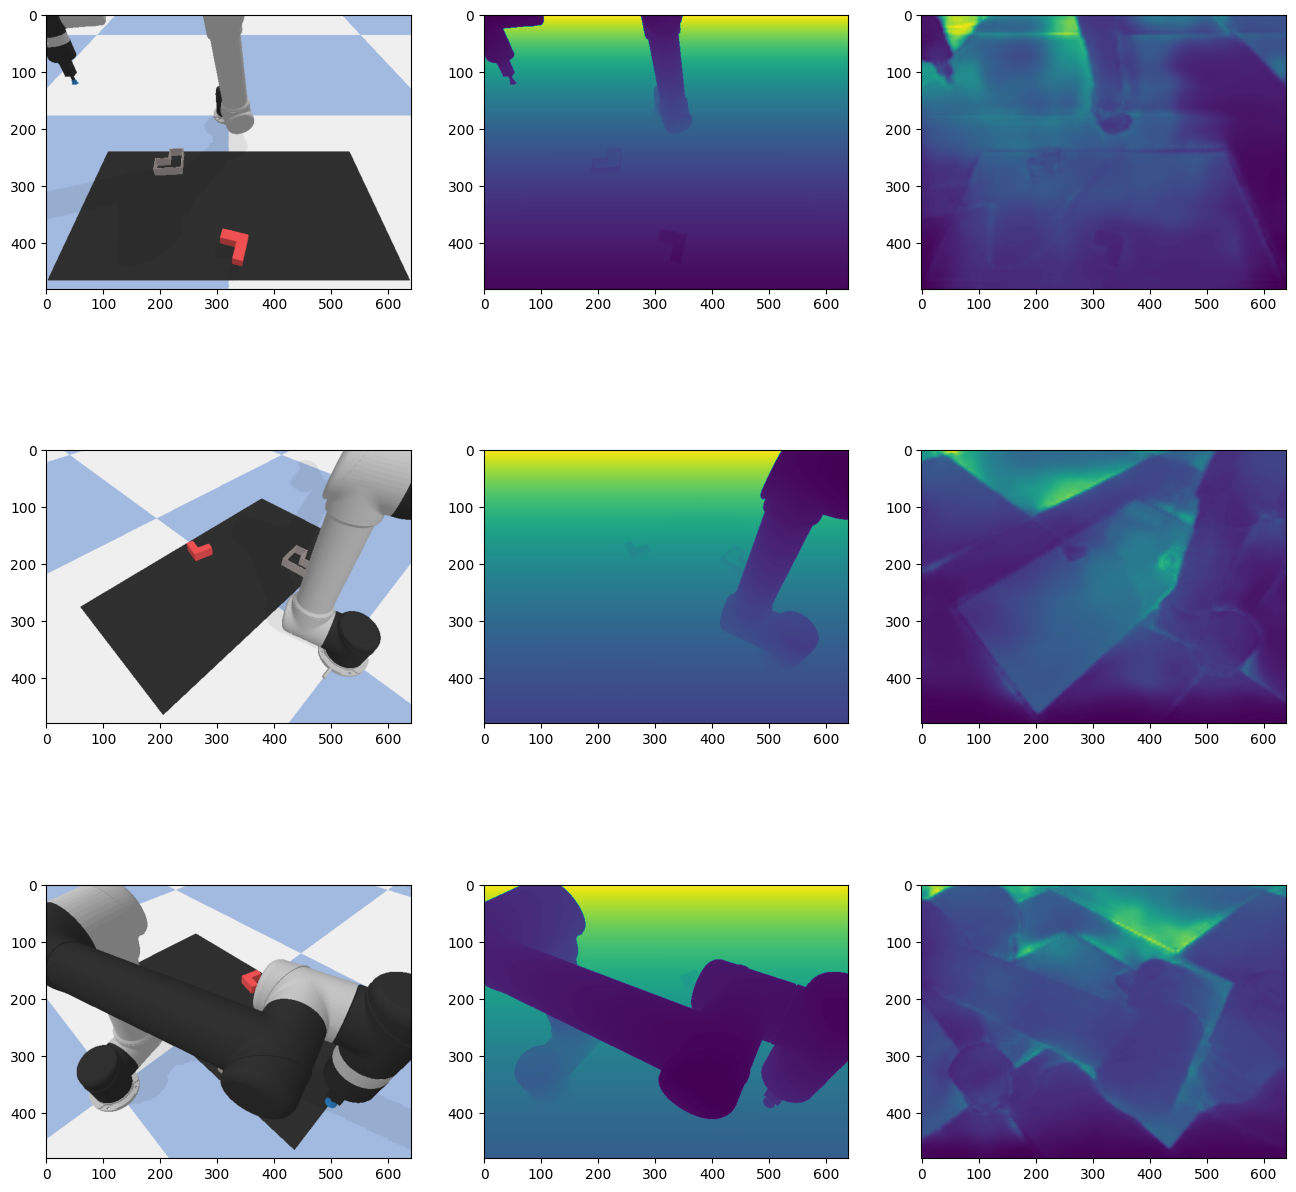

In [29]:
import torch
from torchvision import transforms



a = infer_depth(np.stack(obs["color"], axis=0))

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for index, (col, dep, inf) in enumerate(zip(obs["color"], obs["depth"], a)):
    print(col.shape, dep.shape, inf.shape)
    axs[index, 0].imshow(col)
    axs[index, 1].imshow(dep)
    axs[index, 2].imshow(inf)

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

origin = pickle.load(open("origin.pkl", "rb"))
aug = pickle.load(open("aug.pkl", "rb"))
stacked = pickle.load(open("stacked.pkl", "rb"))

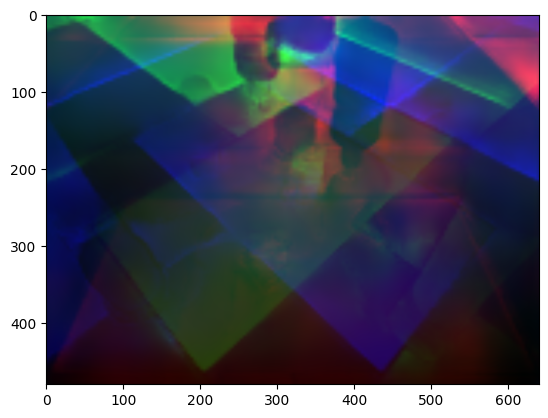

In [5]:
plt.imshow(origin.transpose(1, 2, 0)/255)

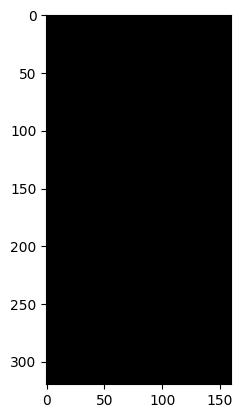

In [8]:
plt.imshow(aug[:, :, 3:])